In [1]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#drive.flush_and_unmount(timeout_ms=24)

In [3]:

import numpy as np
import pandas as pd
import pickle
import numpy as np
import random
import time
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras import optimizers
#from sklearn.metrics import classification_report, confusion_matrix
import sklearn
import seaborn as sn
from keras.callbacks import CSVLogger, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
Dataset_Name = "Bark_101"
base_dir = 'drive/My Drive/Texture/Bark-101-anonymized/Bark-101 Split/'
work_dir = "drive/My Drive/Texture/Bark-101-anonymized/Records/"
#dataset_dir = "drive/My Drive/Plant_Leaf_MalayaKew_MK_Dataset/MK/D2/"

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

#data_instance = 64 # 64 256
color_type = 'rgb' # rgb, grayscale

In [5]:
'''
width_shift_range=0.2,
height_shift_range=0.2,
zoom_range=0.2,
#horizontal_flip=True, 
#vertical_flip=True,
#rotation_range=20,
'''
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.1
                                   )
val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.1
                                 ) 
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
BATCH_SIZE = 8

In [7]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(800, 804),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        color_mode=color_type, # grayscale, rgb
        interpolation="lanczos",
        class_mode='categorical',
        subset='training'
        )

Found 1203 images belonging to 101 classes.


In [8]:
num_classes = train_generator.num_classes
total_train_data = train_generator.samples

print(f"total_train_data = {total_train_data}")
print(f"train_generator.image_shape = {train_generator.image_shape}")
print(f"num_classes = {num_classes}")

total_train_data = 1203
train_generator.image_shape = (800, 804, 3)
num_classes = 101


In [9]:
val_generator = val_datagen.flow_from_directory(
        train_dir,
        target_size=(800, 804),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        color_mode=color_type, # grayscale, rgb
        interpolation="lanczos",
        class_mode='categorical',
        subset='validation'
        )

Found 89 images belonging to 101 classes.


In [10]:
total_val_data = val_generator.samples
print(f"total_val_data = {total_val_data}")

total_val_data = 89


In [11]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(800, 804),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        shuffle=False,
        color_mode=color_type, # grayscale, rgb
        interpolation="lanczos",
        class_mode='categorical'
        )

Found 1295 images belonging to 101 classes.


In [12]:
total_test_data = test_generator.samples
print(f"total_test_data = {total_test_data}")

total_test_data = 1295


In [13]:
# DenseNet121 ResNet101 ResNet50 DenseNet201 InceptionV3 Xception NASNetLarge ResNet152V2 InceptionResNetV2 EfficientNetB7
impl_type = "noTL.Custom2" # TransferLearning3D 
dataset = f"{Dataset_Name}.{color_type}.{train_generator.image_shape[0]}x{train_generator.image_shape[1]}p.DataFlow" # +str(img_size)+"p"
dataset

'Bark_101.rgb.800x804p.DataFlow'

In [14]:
#'''
count_no_improvement = 0
epoch_initial = True
#'''

In [15]:
#NUM_NEURONS = 16
#NUM_LAYERS = 3
#BATCH_SIZE = 16 # 10
NUM_EPOCHS = 2000 # 300, 5
epochs_completed = 0
LEARNING_RATE = 0.00001
EPSILON = 1e-4
early_stop_after_epochs = 50
DROPOUT = 0.5 # 0.5 0.0
pad = 0

LOSS = 'categorical_crossentropy'
ACTIVATION_FUNCTION = 'elu' # relu sigmoid elu
FINAL_ACTIVATION_FUNCTION = 'softmax'
validation_split = 0.1
kernel_size=(1,1)
pointTrainableAfter = "allDefault" # "allDefault" 160 170
OPTIMIZER = "Adam" # Adam SGD RMSProp
init_weights = "None" # "imagenet" None
modelExt = "" # .Dense.128.256.512, .512.512.512 .Dense.512.512.512.512.Res
l2_val = 0.01

# +"_kernel"+str(kernel_size)+"_lr"+str(LEARNING_RATE)+"_batch"+str(BATCH_SIZE)+"_epochs"+str(NUM_EPOCHS)
#checkpointer_name  = "weights_"+dataset+"_"+impl_type+"_nLayers"+str(NUM_LAYERS)+"_nNeurons"+str(NUM_NEURONS)+".hdf5"
ext = f".run_2" # run_1 run_2 .DropAfter .momentum0.9
#'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".actF."+ACTIVATION_FUNCTION+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

checkpointer_name = weights.Bark_101.rgb.800x804p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch8.run_2.hdf5
log_name = log.Bark_101.rgb.800x804p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch8.run_2.log


In [16]:
train_generator.image_shape

(800, 804, 3)

In [17]:
"""
#base_model=DenseNet121(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:]) # `None` (random initialization)
#base_model=ResNet152V2(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:])
# ResNet152V2 ResNet50 ResNet101 ResNet152 DenseNet201 InceptionV3 Xception NASNetLarge 'imagenet' ResNet152V2 DenseNet121
#inputs = Input(final_train_imageset.shape[1:])
#x = ZeroPadding2D(padding=(pad,pad))(inputs)
#base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_tensor=x)
base_model=tf.keras.applications.DenseNet201(weights=init_weights, include_top=False, input_shape=train_generator.image_shape)
x=base_model.output

x = Flatten()(x)

#'''
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
#x_copy = x
x = Dropout(DROPOUT)(x)
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
x = Dense(2048, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
#x = Add()([x,x_copy])
#'''
outputs=Dense(num_classes,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=outputs)
model.summary()
#"""

"\n#base_model=DenseNet121(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:]) # `None` (random initialization)\n#base_model=ResNet152V2(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:])\n# ResNet152V2 ResNet50 ResNet101 ResNet152 DenseNet201 InceptionV3 Xception NASNetLarge 'imagenet' ResNet152V2 DenseNet121\n#inputs = Input(final_train_imageset.shape[1:])\n#x = ZeroPadding2D(padding=(pad,pad))(inputs)\n#base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_tensor=x)\nbase_model=tf.keras.applications.DenseNet201(weights=init_weights, include_top=False, input_shape=train_generator.image_shape)\nx=base_model.output\n\nx = Flatten()(x)\n\n#'''\nx = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)\n#x_copy = x\nx = Dropout(DROPOUT)(x)\nx = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)\nx = Dropout(DROPOUT)

In [18]:
inputs = Input(train_generator.image_shape)
x = inputs

x = Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='valid')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)

x = Flatten()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(l2_val))(x)
x = Activation('elu')(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(l2_val))(x)
x = Activation('elu')(x)
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val))(x)
x = Activation('elu')(x)
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val))(x)
x = Activation('elu')(x)

outputs = Dense(num_classes, activation='softmax')(x)
model=Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 800, 804, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 798, 802, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 798, 802, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 399, 401, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 399, 401, 16)      2320      
_________________________________________________________________
activation_1 (Activation)    (None, 399, 401, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 199, 200, 16)      0     

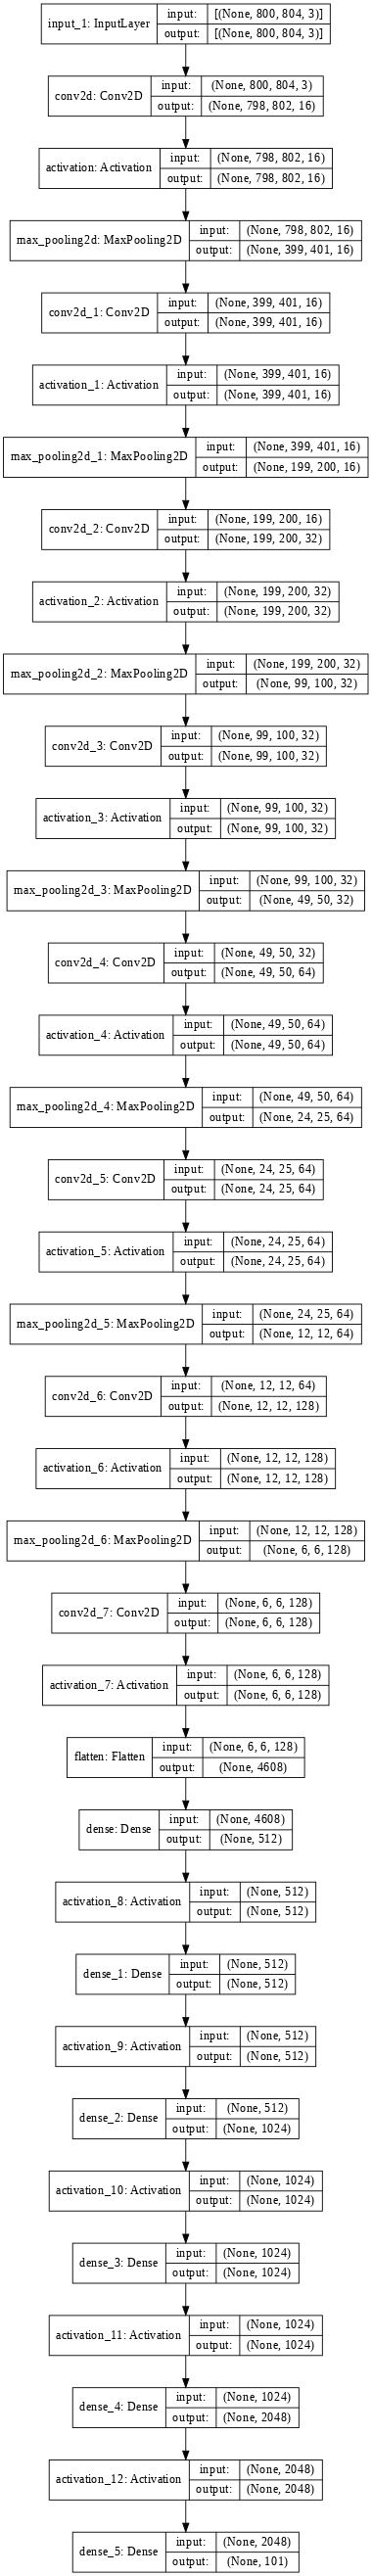

In [19]:
#'''
tf.keras.utils.plot_model(
    model, to_file=work_dir+'Images/model.'+checkpointer_name[8:-5]+'.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64
)
#'''

In [20]:
count_trainable = 0
count_non_trainable = 0

#'''
if pointTrainableAfter == "allDefault":
    for layer in model.layers:
        layer.trainable=True
        count_trainable += 1
elif pointTrainableAfter > 0:
    for layer in model.layers[:pointTrainableAfter]: # [:-pointTrainableAfter]
        layer.trainable=False
        count_non_trainable += 1
    for layer in model.layers[pointTrainableAfter:]: # [-pointTrainableAfter:]
        layer.trainable=True
        count_trainable += 1
#'''

'''
for layer in model.layers:
    layer.trainable=True
    count_trainable += 1
#'''

print("count_non_trainable =", count_non_trainable)
print("count_trainable =", count_trainable)
print("Total number of layers =", count_non_trainable+count_trainable)

count_non_trainable = 0
count_trainable = 36
Total number of layers = 36


In [21]:
'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

'\ncheckpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+                     modelExt+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"\nlog_name = "log."+checkpointer_name[8:-5]+".log"\n\nprint(\'checkpointer_name =\', checkpointer_name)\nprint(\'log_name =\', log_name)\n#'

In [22]:
# "RMSProp" "SGD" "Adam" "Adamax" "Adadelta" "Adagrad" "SGD"
#optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)

if OPTIMIZER == "RMSProp":
    optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)
elif OPTIMIZER == "Adam":
    optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adamax":
    optimizer = tf.keras.optimizers.Adamax(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adadelta":
    optimizer = tf.keras.optimizers.Adadelta(lr = LEARNING_RATE, epsilon=EPSILON, rho=0.95)
elif OPTIMIZER == "Adagrad":
    optimizer = tf.keras.optimizers.Adagrad(lr = LEARNING_RATE, epsilon=EPSILON, initial_accumulator_value=0.1)
elif OPTIMIZER == "SGD":
    optimizer = tf.keras.optimizers.SGD(lr = LEARNING_RATE, momentum=0.9)

model.compile(
    #optimizer=OPTIMIZER,
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy']
)

print("OPTIMIZER =", OPTIMIZER)

OPTIMIZER = Adam


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = work_dir+checkpointer_name, 
                               #monitor='val_accuracy',
                               monitor='val_loss',
                               save_weights_only=False,  
                               mode='auto', 
                               verbose = 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                               save_best_only =False
                               )
checkpointer_best = ModelCheckpoint(filepath = work_dir+"best_"+checkpointer_name, 
                                    monitor='val_loss', 
                                    save_weights_only=False,
                                    mode='auto',  
                                    verbose = 1, 
                                    save_best_only = True
                                    )
early_stopping = EarlyStopping(monitor='loss', patience=early_stop_after_epochs)

In [24]:
'''
if 'count_no_improvement' not in globals():
    count_no_improvement = 0
    print("count_no_improvement =", count_no_improvement)
#'''
'''
count_no_improvement = 2
epoch_initial = False
#'''
min_delta = 0.0009
print("count_no_improvement =", count_no_improvement)

def checkBestPerformance(epoch, logs):
    save_filepath = work_dir+"best_"+checkpointer_name

    global epoch_initial
    if epoch_initial == True:
        epoch_initial = False
        model.save(filepath = save_filepath)
        print(". Model saved!")

    elif epoch_initial == False:
        global count_no_improvement

        log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['val_loss', 'val_accuracy'], engine='python')
        min_val_loss = float(str(min(log_data.val_loss.values))[:6])
        max_val_acc = float(str(max(log_data.val_accuracy.values))[:6])

        current_val_acc = float(str(logs['val_accuracy'])[:6])
        current_val_loss = float(str(logs['val_loss'])[:6])

        if (current_val_loss < min_val_loss) and (abs(current_val_loss-min_val_loss) >= min_delta):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_loss decreased from",min_val_loss," to",current_val_loss,"( val_accuracy =",current_val_acc,").")

        elif (current_val_loss==min_val_loss) and (current_val_acc>max_val_acc):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_accuracy increased to", current_val_acc, ".")

        else:
            count_no_improvement += 1
            print(". count_no_improvement =", count_no_improvement)

        if count_no_improvement >= early_stop_after_epochs:
            global list_callbacks
            del list_callbacks, count_no_improvement
            #print("count_no_improvement =", count_no_improvement, "... list_callbacks =", list_callbacks)

count_no_improvement = 0


In [25]:
epochs_completed = 0
list_callbacks = []
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)

#if 'list_callbacks' in globals():
#    del list_callbacks

try:
    log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
    epochs_completed = log_data.shape[0]

    #if epochs_completed > 0:
    model = load_model(work_dir+checkpointer_name)
    list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
    print("epochs_completed =", epochs_completed)

except Exception as error:
    if epochs_completed == 0:
        # list_callbacks = [checkpointer, checkpointer_best, csv_logger, early_stopping] 
        list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
        print("epochs_completed =", epochs_completed)
    elif epochs_completed > 0:
        print(error)

print('checkpointer_name =', checkpointer_name)

epochs_completed = 0
checkpointer_name = weights.Bark_101.rgb.800x804p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch8.run_2.hdf5


In [26]:
print('checkpointer_name =', checkpointer_name)
print("Previously completed epochs =", epochs_completed)
print("count_no_improvement =", count_no_improvement, "\n")

#'''
try:
    start_time = time.time()
    history = model.fit(train_generator, 
                        steps_per_epoch=total_train_data // BATCH_SIZE,
                        shuffle=True, 
                        epochs = NUM_EPOCHS - epochs_completed, 
                        validation_data=val_generator,
                        validation_steps=total_val_data // BATCH_SIZE,
                        callbacks=list_callbacks
                        )
    elapsed_time = time.time() - start_time 
    print("\nTime elapsed: ", elapsed_time)

except Exception as error:
    print("\nError:", error)
#'''

checkpointer_name = weights.Bark_101.rgb.800x804p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch8.run_2.hdf5
Previously completed epochs = 0
count_no_improvement = 0 

Epoch 1/2000
150/150 [==============================] - 57s 350ms/step - loss: 8.9497 - accuracy: 0.0561 - val_loss: 8.4943 - val_accuracy: 0.0682

Epoch 00001: saving model to drive/My Drive/Texture/Bark-101-anonymized/Records/weights.Bark_101.rgb.800x804p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch8.run_2.hdf5
. Model saved!
Epoch 2/2000
150/150 [==============================] - 52s 344ms/step - loss: 8.7572 - accuracy: 0.0661 - val_loss: 8.4045 - val_accuracy: 0.0682

Epoch 00002: saving model to drive/My Drive/Texture/Bark-101-anonymized/Records/weights.Bark_101.rgb.800x804p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch8.run_2.hdf5

val_loss decreased from 8.4943  

In [27]:
# weights.Bark_101.rgb.800x804p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch8.run_2.hdf5


In [28]:
'''
Record: Bark_101_impl_1_800x804p_RGB_Custom_noTL_DataFlow: (41.9%; 56.06%)
;
---

#'''
'''
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]

result = model.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
print("Test Acc: {}, Test Loss: {}: ep{}, {}\n".format(round(result[1],4), round(result[0],4), epochs_completed, checkpointer_name))
#'''

'\ncsv_logger = CSVLogger(work_dir+log_name, separator=\',\', append=True)\nlog_data = pd.read_csv(work_dir+log_name, sep=\',\', usecols=[\'epoch\'], engine=\'python\')\nepochs_completed = log_data.shape[0]\n\nresult = model.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)\nprint("Test Acc: {}, Test Loss: {}: ep{}, {}\n".format(round(result[1],4), round(result[0],4), epochs_completed, checkpointer_name))\n#'

In [29]:
#checkpointer_name = "weights.Fashion.DenseNet121.wInit.None.TrainableAfterallDefault.opt.SGD.drop.0.0.batch32.Flatten.run_1.hdf5"
model_loaded = load_model(work_dir+"best_"+checkpointer_name)
print("Loaded "+work_dir+"best_"+checkpointer_name+".")

Loaded drive/My Drive/Texture/Bark-101-anonymized/Records/best_weights.Bark_101.rgb.800x804p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch8.run_2.hdf5.


In [30]:
'''
Record: Bark_101_impl_1_800x804p_RGB_Custom_noTL_DataFlow: (41.9%; 56.06%)
;
---

#'''
'''
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]
#'''

result2 = model_loaded.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
#print("nLayers: {}, nNeurons: {}, DROPOUT: {}, Test Acc: {}, Test Loss: {}".format(NUM_LAYERS, NUM_NEURONS, DROPOUT, round(result2[1], 4), round(result2[0], 4)))
print("Test Acc: {}, Test Loss: {}: ep{}, {}\n".format(round(result2[1],4), round(result2[0],4), epochs_completed, "best_"+checkpointer_name))


161/161 [==============================] - 46s 286ms/step - loss: 7.7046 - accuracy: 0.1825
Test Acc: 0.1825, Test Loss: 7.7046: ep0, best_weights.Bark_101.rgb.800x804p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch8.run_2.hdf5



In [31]:
import csv

with open(work_dir+'Records.'+checkpointer_name[8:-5]+'.csv', "a") as fp:
    wr = csv.writer(fp, dialect='excel')
    try:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4), elapsed_time])
    except:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4)])
print("Saved results.")

Saved results.


In [32]:
#Confution Matrix and Classification Report
#'''
Y_pred = model_loaded.predict_generator(test_generator, verbose=1)
#'''
#'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


162/162 [==============================] - 44s 268ms/step
Saved: drive/My Drive/Texture/Bark-101-anonymized/Records/Y_pred.Bark_101.rgb.800x804p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch8.run_2


In [33]:
'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

'\nsave_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"\nnp.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)\nprint(f"Saved: {work_dir}{save_predictions_filename}")\n#'

In [34]:
#Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename_2}.npy", allow_pickle=True)
Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename}.npy", allow_pickle=True)
print(f"Y_pred_loaded.shape = {Y_pred_loaded.shape}")

Y_pred_loaded.shape = (1295, 101)


In [35]:
y_pred = np.argmax(Y_pred_loaded, axis=1)

In [36]:
y_true = test_generator.classes

In [37]:
list_class_names_in_generator = list(test_generator.class_indices.keys())
list_class_names_in_generator[:5]

['0', '1', '10', '100', '11']

In [38]:
len(list_class_names_in_generator)

101

In [39]:
list_y_true_rearranged = []
list_y_pred_rearranged = []

for true_class,pred_class in zip(y_true,y_pred):
    #print(f"true_class = {true_class}; pred_class = {pred_class}")
    #y_true_rearranged = int(list_class_names_in_generator[true_class][5:])
    #y_pred_rearranged = int(list_class_names_in_generator[pred_class][5:])

    y_true_rearranged = int(list_class_names_in_generator[true_class])
    y_pred_rearranged = int(list_class_names_in_generator[pred_class])

    list_y_true_rearranged.append(y_true_rearranged)
    list_y_pred_rearranged.append(y_pred_rearranged)

In [40]:
np_y_true_rearranged = np.array(list_y_true_rearranged)
np_y_pred_rearranged = np.array(list_y_pred_rearranged)

print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}")
print(f"np_y_pred_rearranged.shape = {np_y_pred_rearranged.shape}")
print(f"np_y_true_rearranged: {np_y_true_rearranged}")
print(f"np_y_pred_rearranged: {np_y_pred_rearranged}")

np_y_true_rearranged.shape = (1295,)
np_y_pred_rearranged.shape = (1295,)
np_y_true_rearranged: [ 0  0  0 ... 99 99 99]
np_y_pred_rearranged: [61 66 75 ...  9 21 13]


In [41]:
print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}\n")

index = -5
print(f"y_true[{index}:] = {y_true[index:]}")
print(f"y_pred[{index}:] = {y_pred[index:]}\n")
print(f"np_y_true_rearranged[{index}:] = {np_y_true_rearranged[index:]}")
print(f"np_y_pred_rearranged[{index}:] = {np_y_pred_rearranged[index:]}\n")
print(f"np.unique(np_y_true_rearranged) = {np.unique(np_y_true_rearranged)}")
print(f"np.unique(np_y_pred_rearranged) = {np.unique(np_y_pred_rearranged)}")

np_y_true_rearranged.shape = (1295,)

y_true[-5:] = [100 100 100 100 100]
y_pred[-5:] = [90 79 90 15  6]

np_y_true_rearranged[-5:] = [99 99 99 99 99]
np_y_pred_rearranged[-5:] = [ 9  8  9 21 13]

np.unique(np_y_true_rearranged) = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
np.unique(np_y_pred_rearranged) = [ 0  2  3  8  9 11 12 13 15 16 19 21 22 23 26 29 30 31 35 38 39 41 49 50
 51 53 54 55 56 58 61 62 65 66 75 78 79 84 87 90 93 95 99]


In [42]:
conf_matrix = sklearn.metrics.confusion_matrix(np_y_true_rearranged, np_y_pred_rearranged)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


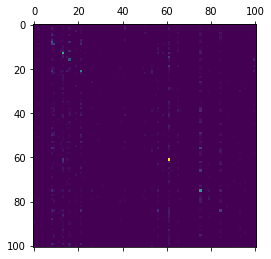

In [43]:
#plt.figure(figsize = (30,30))
plt.matshow(conf_matrix)

In [44]:
df_conf_matrix = pd.DataFrame(conf_matrix, index = [f"Class {i+1}" for i in range(num_classes)],
                  columns = [f"Class {i+1}" for i in range(num_classes)])

img_path = drive/My Drive/Texture/Bark-101-anonymized/Records/Images/conf_matrix_Bark_101.rgb.800x804p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch8.run_2.png


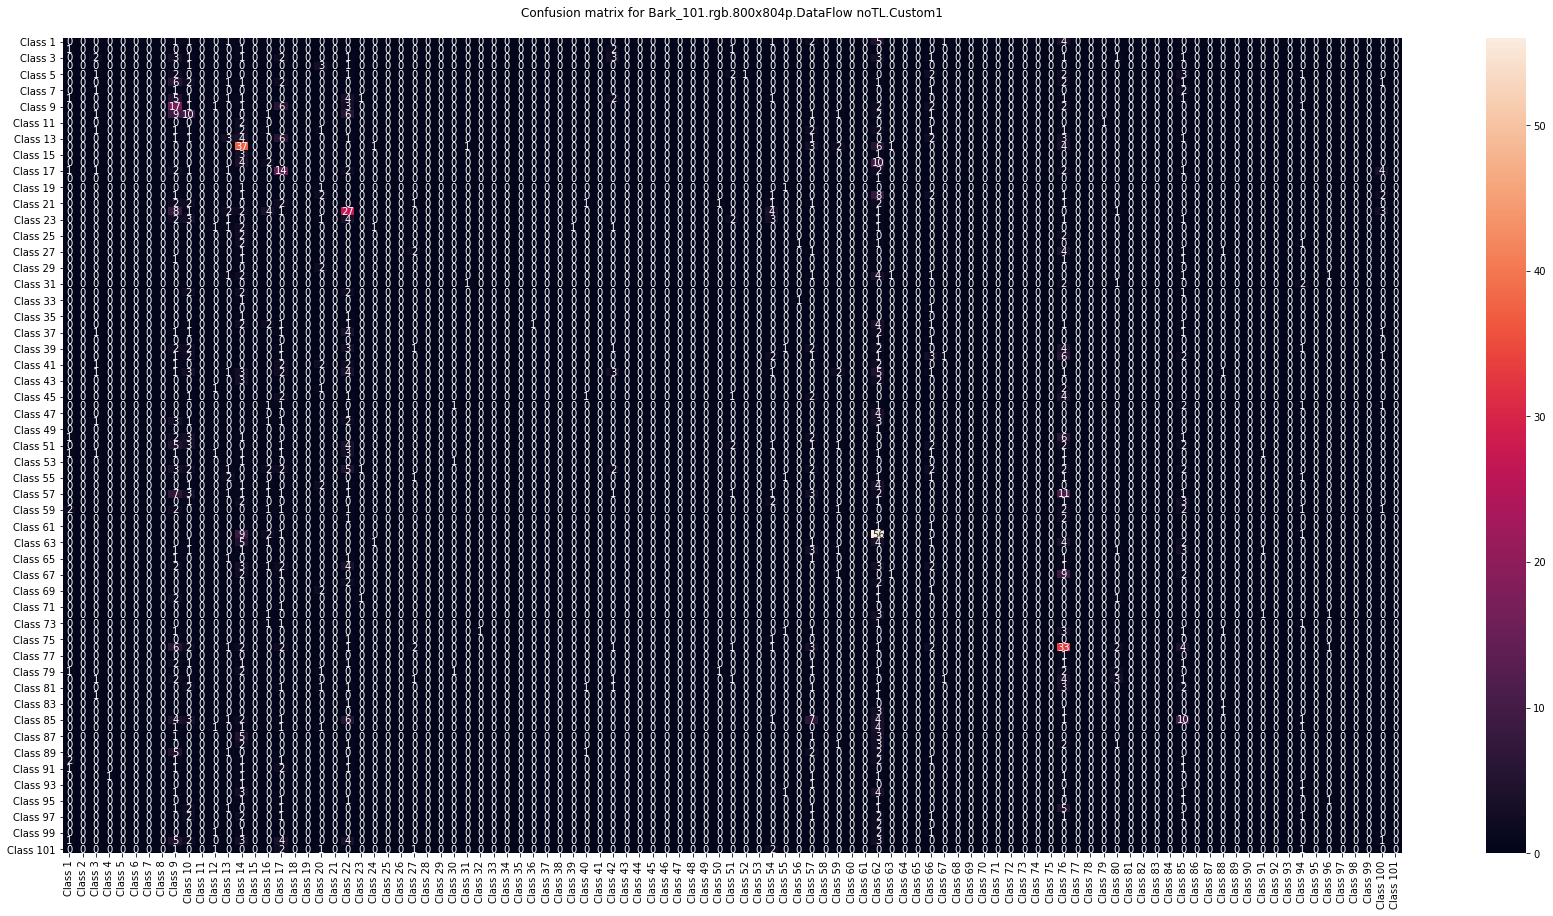

In [45]:
title = "Confusion matrix for "+dataset+" "+impl_type+"\n"
plt.figure(figsize = (30,15))
plt.title(title)
sn.heatmap(df_conf_matrix, annot=True)

img_path = work_dir+'Images/conf_matrix_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
print(f"img_path = {img_path}")

In [46]:
#Confution Matrix and Classification Report
'''
Y_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(sklearn.metrics.confusion_matrix(np_test_label, y_pred))
#'''

"\nY_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))\ny_pred = np.argmax(Y_pred, axis=1)\nprint('Confusion Matrix')\nprint(sklearn.metrics.confusion_matrix(np_test_label, y_pred))\n#"

In [47]:
# Precision [TP/TP+FP] = The ratio of correctly predicted positive observations to the total predicted positive observations.
# Recall (Sensitivity) [TP/TP+FN] = The ratio of correctly predicted positive observations to the all observations in actual class - 'yes'.
# F1 score [F1 Score = 2*(Recall * Precision) / (Recall + Precision)] = The weighted average of Precision and Recall.
# Support = The number of samples of the true response that lie in that class.
'''
print('Classification Report:')
print(sklearn.metrics.classification_report(test_generator.classes, y_pred))
#'''

"\nprint('Classification Report:')\nprint(sklearn.metrics.classification_report(test_generator.classes, y_pred))\n#"

In [48]:
test_generator.class_indices.keys()

dict_keys(['0', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'])

In [49]:
#'''
print('Classification Report')
print(sklearn.metrics.classification_report(np_y_true_rearranged, np_y_pred_rearranged, target_names=test_generator.class_indices.keys()))
#'''

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00         5
          10       0.14      0.10      0.12        20
         100       0.00      0.00      0.00         5
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        17
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00        19
          15       0.13      0.47      0.21        36
          16       0.14      0.31      0.20        32
          17       0.00      0.00      0.00         3
          18       0.00      0.00      0.00        13
          19       0.14      0.13      0.13        23
           2       0.27      0.67      0.38        55
          20       0.00      0.00      0.00         4
          21       0.09      0.12      0.10        16
          22       0.19      0.45      0.27        31
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
log_data = pd.read_csv(work_dir+log_name, sep=',', engine='python') 

In [51]:
# Getting the model history keys 
#history.history.keys()
log_data.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.056067,8.949705,0.068182,8.494341
1,1,0.066109,8.757246,0.068182,8.404450
2,2,0.071130,8.700987,0.079545,8.354239
3,3,0.091213,8.602625,0.102273,8.248398
4,4,0.101255,8.520157,0.136364,8.238191


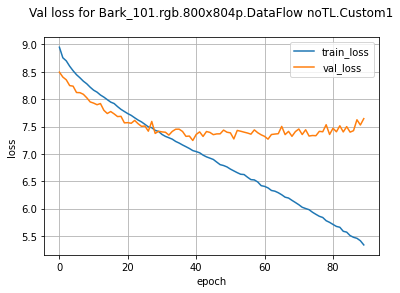

img_path = drive/My Drive/Texture/Bark-101-anonymized/Records/Images/vLoss_Bark_101.rgb.800x804p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch8.run_2.png


In [52]:
# plot the training artifacts
title = "Val loss for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['loss'])
plt.plot(log_data['val_loss'])
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'Images/vLoss_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)

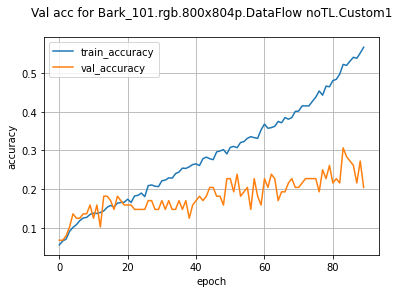

img_path = drive/My Drive/Texture/Bark-101-anonymized/Records/Images/vAcc_Bark_101.rgb.800x804p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch8.run_2.png


In [53]:
title = "Val acc for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['accuracy'])
plt.plot(log_data['val_accuracy'])
plt.title(title)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'Images/vAcc_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)